In [1]:
%matplotlib inline
import torchnlp.nn as nlp
import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.nn.utils.rnn import *
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation

In [9]:
# load all that we need
dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz', allow_pickle=True)  # dev
fixtures_gen = np.load('../fixtures/generation.npy', allow_pickle=True)  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz', allow_pickle=True)  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy', allow_pickle=True)  # test
vocab = np.load('../dataset/vocab.npy', allow_pickle=True)

In [10]:
# sentence_level_dataset = []
# for article in dataset:
#     eos = np.where(article == 1417)[0] + 1
#     sentences = np.split(article, eos)
#     sentence_level_dataset.extend(sentences)

In [11]:
sentence_level_dataset = []
seq_len = 300
p = 0.95
for article in dataset:
    num = article.shape[0]
    i = 0
    eos = []
    for n in range(num // 150):
        if i < num:
            pp = np.random.uniform(0, 1)
            if pp < p:
                eos.append(i + seq_len)
                i += seq_len
            else:
                eos.append(i + seq_len // 2)
                i += seq_len // 2
    eos = np.asarray(eos)
    sentences = np.split(article, eos)
    sentence_level_dataset.extend(sentences)

In [12]:
dataset = []
for sen in sentence_level_dataset:
    if sen.shape[0] > 1:
        dataset.append(sen)

In [13]:
dataset = np.asarray(dataset)

In [14]:
# data loader

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __iter__(self):
        # concatenate your articles and build into batches
        if self.shuffle == True:
            np.random.shuffle(self.dataset)
        bs = self.batch_size
        num_batch = self.dataset.shape[0] // bs
        for i in range(num_batch):
            batch_data = self.dataset[i:i+bs]
#             inputs = [torch.LongTensor(line[:-1]) for line in batch_data]
#             targets = [torch.LongTensor(line[1:]) for line in batch_data]
            yield ([torch.LongTensor(line[:-1]) for line in batch_data], [torch.LongTensor(line[1:]) for line in batch_data])    

In [18]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size, embed_size, hidden_size, nlayers):
        super(LanguageModel, self).__init__()
        self.vocab_size=vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.nlayers=nlayers
        self.embedding = nn.Embedding(vocab_size,embed_size) # Embedding layer
        self.rnn = nn.LSTM(input_size = embed_size,hidden_size=hidden_size,num_layers=nlayers,dropout=0.2) # Recurrent network
        self.scoring = nn.Linear(hidden_size,vocab_size) # Projection layer
        self.scoring.weight = self.embedding.weight
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        batch_size = len(x)
        inp = [i for i in x]
        for idx, sentence in enumerate(inp):
            inp[idx] = self.dropout(self.embedding(sentence))
            
        embed = pack_sequence(inp,enforce_sorted=False)
        hidden = None
        output_lstm,hidden = self.rnn(embed,hidden) #L x N x H
        output_lstm,length = pad_packed_sequence(output_lstm)
        output_lstm_no_pad = []
        for idx in range(batch_size):
            output_lstm_no_pad.append(output_lstm[:,idx,:][:length[idx]])
        output_lstm_flatten = torch.cat(output_lstm_no_pad)
        output_flatten = self.scoring(output_lstm_flatten) #(L*N) x V
        result = output_flatten.argmax(dim=1)
        output = []
        idx = 0
        for i in range(batch_size):
            output.append(output_flatten[idx:idx+length[i]])
            idx = idx+length[i]
        out = []
        idx = 0
        for i in range(batch_size):
            out.append(result[idx:idx+length[i]])
            idx = idx+length[i]
        return output_flatten, output, out

#         return output_lstm

In [19]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = [] 
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        self.criterion = self.criterion.cuda()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            loss, time = self.train_batch(inputs, targets)
            epoch_loss += loss
            print('Time:', time, 'Loss:', loss, end='\r')
            torch.cuda.empty_cache()
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('\n[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        start = time.time()
        inputs = [i.cuda() for i in inputs]
        targets = torch.cat(targets).cuda()
        outputs, _, _ = self.model.forward(inputs)
        batch_loss = 0
        batch_loss = self.criterion(outputs, targets)
#         loss = criterion(outputs.view(-1,outputs.size(2)),targets.view(-1)) # Loss of the flattened outputs
        self.optimizer.zero_grad()
        batch_loss.backward()
        self.optimizer.step()
        end = time.time()
        return batch_loss.item(), end - start
    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [20]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        num_seq = inp.shape[0]
        
        sequence = [torch.LongTensor(inp[i]).cuda() for i in range(num_seq)]
        out_flatten, out, _ = model.forward(sequence)
        pred = [out[i][-1].detach().cpu() for i in range(len(out))]
        pred = np.array(torch.stack(pred))
        return pred

        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """        
        num_seq = inp.shape[0]
        
        sequence = [torch.LongTensor(inp[i]).cuda() for i in range(num_seq)]
        out_flatten, _, out = model.forward(sequence)
        
        next_word = [out[i][-1].view(1) for i in range(len(out))]
        generation = next_word
        new_sequence = [torch.cat([sequence[i], next_word[i]]) for i in range(len(sequence))]

        for n_word in range(forward-1):
            out_flatten, _, out = model.forward(new_sequence)
            next_word = [out[i][-1].view(1) for i in range(len(out))]
            new_sequence = [torch.cat([new_sequence[i], next_word[i]]) for i in range(len(sequence))]
            generation = [torch.cat([generation[i].cpu(), next_word[i].cpu()]) for i in range(len(generation))]
        generation = torch.stack(generation).numpy()
        return generation

In [24]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 8
BATCH_SIZE = 8


In [25]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1574409843


In [26]:
model = LanguageModel(len(vocab),512,512,4)
model = model.cuda()
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [28]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()

Time: 0.08829855918884277 Loss: 6.2655134201049805
[TRAIN]  Epoch [2/8]   Loss: 6.5995
[VAL]  Epoch [2/8]   Loss: 5.7240
Saving model, predictions and generated output for epoch 0 with NLL: 5.7240357
Time: 0.08940696716308594 Loss: 6.0140638351440435
[TRAIN]  Epoch [3/8]   Loss: 5.9849
[VAL]  Epoch [3/8]   Loss: 5.3289
Saving model, predictions and generated output for epoch 1 with NLL: 5.3289375
Time: 0.0844113826751709 Loss: 5.662783145904541455.7058186531066895
[TRAIN]  Epoch [4/8]   Loss: 5.7065
[VAL]  Epoch [4/8]   Loss: 5.1974
Saving model, predictions and generated output for epoch 2 with NLL: 5.197402
Time: 0.08645439147949219 Loss: 5.5339198112487795
[TRAIN]  Epoch [5/8]   Loss: 5.5238
[VAL]  Epoch [5/8]   Loss: 4.8722
Saving model, predictions and generated output for epoch 3 with NLL: 4.872234
Time: 0.08043622970581055 Loss: 5.35037994384765655.412330627441406
[TRAIN]  Epoch [6/8]   Loss: 5.3770
[VAL]  Epoch [6/8]   Loss: 4.7845
Saving model, predictions and generated output

In [29]:
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()

Time: 0.08361434936523438 Loss: 5.3015861511230475
[TRAIN]  Epoch [10/8]   Loss: 5.0323
[VAL]  Epoch [10/8]   Loss: 4.6337
Time: 0.08559441566467285 Loss: 4.9341535568237305
[TRAIN]  Epoch [11/8]   Loss: 4.9404
[VAL]  Epoch [11/8]   Loss: 4.6186
Time: 0.07928133010864258 Loss: 4.8148989677429215
[TRAIN]  Epoch [12/8]   Loss: 4.9122
[VAL]  Epoch [12/8]   Loss: 4.6415
Time: 0.08373284339904785 Loss: 4.8244585990905765
[TRAIN]  Epoch [13/8]   Loss: 4.8611
[VAL]  Epoch [13/8]   Loss: 4.5575
Saving model, predictions and generated output for epoch 3 with NLL: 4.5575223
Time: 0.08637189865112305 Loss: 4.6906929016113285
[TRAIN]  Epoch [14/8]   Loss: 4.7729
[VAL]  Epoch [14/8]   Loss: 4.4475
Saving model, predictions and generated output for epoch 4 with NLL: 4.4474525
Time: 0.08555173873901367 Loss: 4.9631700515747075
[TRAIN]  Epoch [15/8]   Loss: 4.7787
[VAL]  Epoch [15/8]   Loss: 4.4532
Time: 0.0842139720916748 Loss: 4.69238233566284265
[TRAIN]  Epoch [16/8]   Loss: 4.7423
[VAL]  Epoch [16

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=1e-6)
# criterion = nn.CrossEntropyLoss().cuda()

In [ ]:
# for batch_num, (inputs, targets) in enumerate(loader):
#     inputs = [i.cuda() for i in inputs]
# #     targets = torch.cat(targets).cuda()
#     outputs, out = model.forward(inputs)
#     break
# #     loss = criterion(outputs, targets)
# #     optimizer.zero_grad()
# #     loss.backward()
# #     optimizer.step()

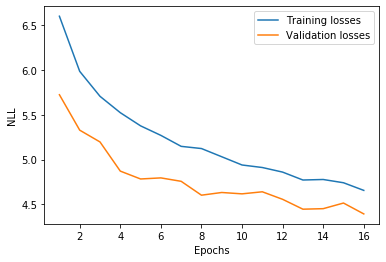

In [30]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [31]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | the most common and most common of the United States
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = <eol> In the United States , the
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | single , and the second single from the album was
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | <unk> , <unk> , <unk> , <unk> , <unk> ,
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | position in the United States . The <unk> was also
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | was awarded the <unk> Prize of the Year . The
Input | Output #6: 

In [32]:
run_id

'1574409843'

In [ ]:
!cp experiments/1574406970/predictions-test-10.npy predictions.npy
!cp experiments/1574406970/generated-10.txt generated.txt
!cp experiments/1574406970/generated_logits-test-10.npy generated_logits.npy
!tar -cvf handin.tar training.ipynb predictions.npy generated.txt generated_logits.npy
# !rm -f generated.txt predictions.npy training.ipynb generated_logits.npy